In [1]:
# Check out the library module "uwavy.py" for more details
from uwavy import *

# UWavy Navigation - Solution

1. [Overview](#Overview)
2. [Inertial Navigation](#Inertial-Navigation)
3. [Image Recognition](#Image-Recognition)
4. [Synthesis](#Synthesis)
5. [Conclusion](#Conclusion)

## Overview



## Inertial Navigation

### Generating a "True" Path

Our coordinate system used in this simulation is simply the pixel grid of the reference image. This will be discussed in more detail in the image recognition section, but the inertial navigation system uses the same coordinates for simplicity. This coordinate system could be scaled or shifted linearly in any direction and with any magnitude, and our system would not be affected. The pixel grid was simply chosen for simplicity.

The paths used by our simulation are generated by first generating an array of changes in displacement. We chose this method because it allows us to easily add systematic error to our simulation of the inertial measurement unit. In addition, is easy to construct complex shapes and paths with this method, because the changes in position will be constant, regardless of the absolute position of the drone.
[TODO: Animation]



In [2]:
# Set out a path, starting at START_POS and following updates along DELTAS_TRUE
start_pos = np.array([[1500,850]])
deltas_true = (np.vstack((np.vstack([s_turn(1) for _ in range(3)]), wide_uturn(3))) * 25).astype(np.float64)
path_true = np.cumsum(np.vstack((start_pos, deltas_true)), axis=0)

## TODO Plot path_true

### Introducing Systematic and Random Error

From our research of Inertial Measurement Units, we decided that there were two  types of errors that we wanted to simulate in order to faithfully simulate an actual IMU.
1. The first type of error is systematic error, which would stem from the calibration of the unit not being accurate. For example, this could mean that the unit consistently measures that its momentum to the northeast is higher than it actually is, meaning its measured position is consistently more to the northeast. We simulate this by adding a constant error to every delta in the array. This error is usually small on a millitary quality drone, but over long periods of time, this type of error will invevitably show up. We tried to make our simulated error larger than we expect in practice.
2. The other type of error is random error. This type of error would stem from the uncertainty of the unit. IMUs cannot have infinite precision, and so there will be some uncertainty. Like systemic error, on millitary quality drones, this will be small, but on long flights this error will compound. We simulated this error by adding a random error generated from a gaussian distribution

In [3]:
# Add systematically biased error 
deltas_sys_error = (deltas_true - np.array([3, -1])).astype(np.float64)
#Add random error
deltas_sys_and_rand = (deltas_sys_error - np.random.random_sample(deltas_true.shape))

path_IMU = np.cumsum(np.vstack((start_pos, deltas_sys_and_rand)), axis=0)

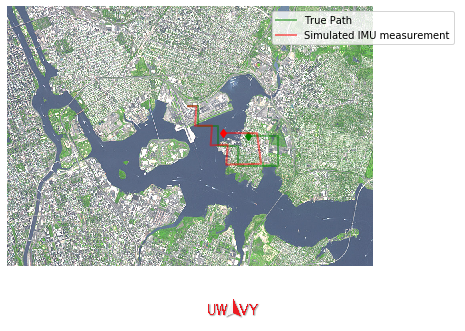

In [4]:
ani = FlightAnimator(framerate=500)
ani.addPath(path_true, label="True Path", color="green")
ani.addPath(path_IMU, label="Simulated IMU measurement", color="red")
HTML(ani.toHTML5Video())

## Image Recognition
As can be seen abocve, inertial navigation on its own is not very impressive, but combining it with images taken from a drone's onboard camera can yield exceptional results. This section explains how the image recognition part of the software works by examining some of the underlying algorithms and walking through a simple demo.


### Simulating the image database

In practive, a drone will use its onboard camera to take an image of the ground. This image must be matched with a reference image whose location is already known. A match indicates that the position of the drone is the same as the position of the reference image.

We simulate this process using a single reference image. In practice, we could have many images, layered on top of each other and stiched together, but this most basic MVP serves as a compelling proof of concept. Our reference image—seen below—is a [map of New York City](https://en.wikipedia.org/wiki/File:Aster_newyorkcity_lrg.jpg) comprising all five boroughs with a resolution of 5,125 pixels per square kilometer. Future iterations will use multiple such images stiched together, but this should work fairly well for navigation about a single city such as New York. 

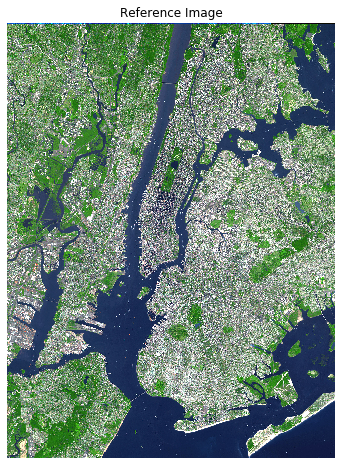

In [5]:
plot_ref_img();

### Simulating the onboard camera
In the real world, a drone will use its onboard camera to capture an image of the ground directly beneath it. The area of terrain captured will depend on the focal length of the camera, which is known beforehand, and the altitude of the drone, which can be measured in real time. Thus, the image captured will be a rectangle — we chose to model it as a square for simplicity — with the drone's actual location at the center. 

This definition allows a straightforward simulation of the drone's onboard camera. "Taking a picture" in the simulation just means taking a slice of the reference image of a given size with the drone's true position — which is known exactly in the simulation — at the center. This of course does not account for changes in lighting, shadows or other movable objects, but we found we achieved promising results that validated our MVP with just this simple model. 

A function to simulate taking a picture from the drone's camera could look something like this (see [library module](TODO) for more detail):
```python
def take_picture(img, pos, radius):
    return img[pos.x - radius : pos.x + radius, pos.y - radius : pos.y + radius]
```

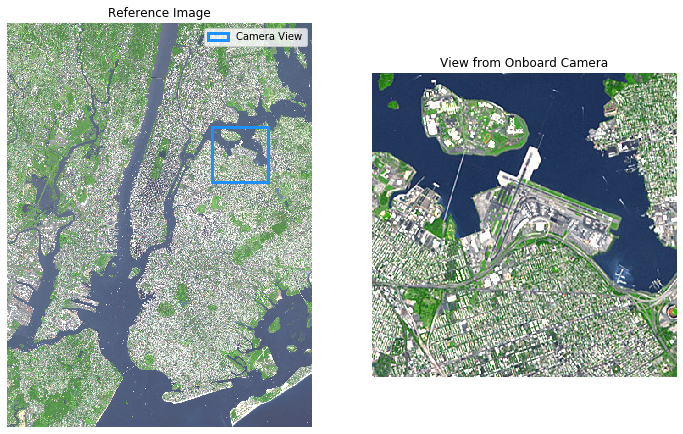

In [6]:
pos = np.array((850,1500))

ax = plt.subplot(1,2,1)
plot_ref_img(ax, pos)

img = take_picture(pos)

plt.subplot(1,2,2)
plt.imshow(img)
plt.title("View from Onboard Camera")
plt.axis('off');

### Comparing the captured image with the database
To determine if the drone is in a particular location, we compare the image taken by the drone's camera with identically sized slices from the reference image. When the two images match, we know that the drone must be at the exact center of the matching slice. We define a straightforward algorithm for matching image slices: compare each pixel value for value and take the mean squared error, i.e.
```python
error = np.sum(np.square(test_slice - ref_slice)) / num_pixels
```
where test_slice is the image captured from the camera and ref_slice is a slice from the database.

The graphic below demonstrates the result of searching across a horizontal line spanning the width of the image. The red line plots the result of the error function above as the test_slice slides across the line. As you can see, the minimum error occurs when the center of the test slice is at the actual position of the drone, indicating a match.

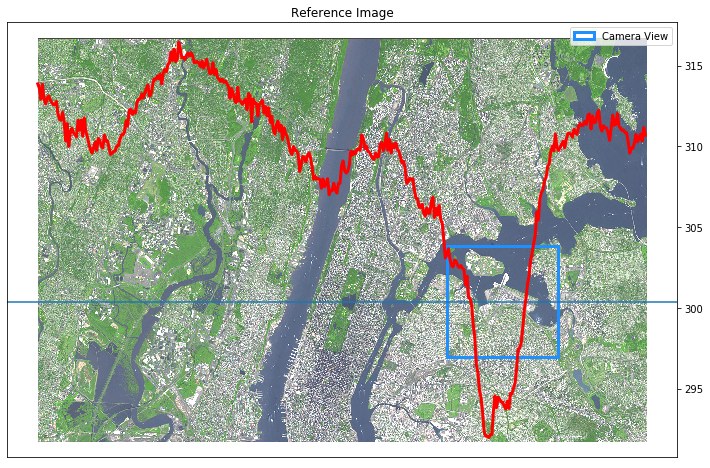

In [7]:
ax = plt.subplot(1,1,1)
plot_ref_img(ax, pos, crop_height=.5)
plot_line_error(pos, ax)
# TODO deal with lengend

### Searching the database for the captured image

We can replicate this process by searching the entire map for a matching slice. The below graphic uses the same technique as above but we use a heatmap to plot the error. As can be seen, the point corresponding to the smallest error value is exactly the true position of the drone.

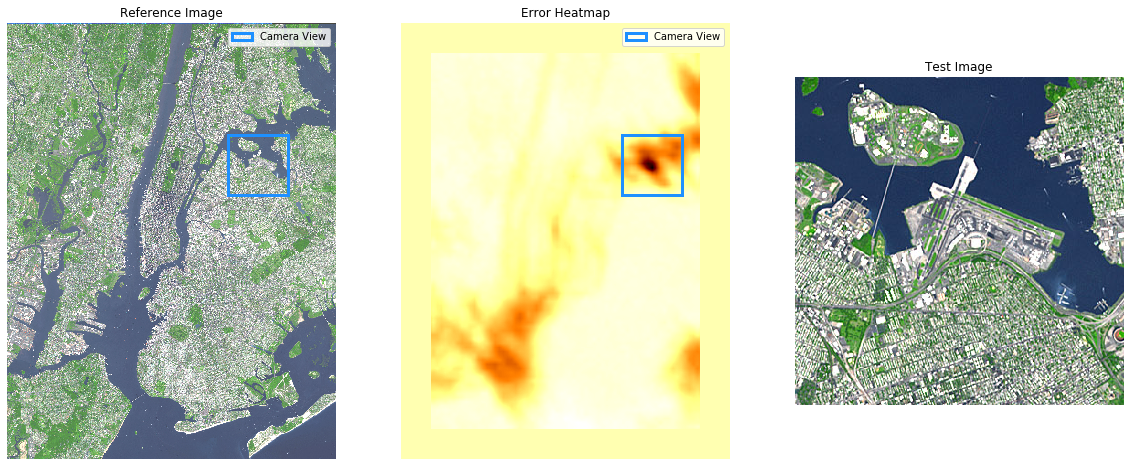

In [8]:
plt.figure(figsize=(20,15))
ax = plt.subplot(1,3,1)
plot_ref_img(ax, pos)

ax = plt.subplot(1,3,2)
plot_ref_img(ax, pos)
plot_heat_map(pos, ax)

img = take_picture(pos)

plt.subplot(1,3,3)
plt.imshow(img)
plt.title("Test Image")
plt.axis('off');

## Synthesis

### Informing the Search Algorithm
1. Starting Point = from intertial nav
1. Sprial Pattern
1. Search Confidence
### Combining Intertial + Image Recognition
1. Putting the pieces together
[Animation with both inertial + img rec]

In [9]:
ani = FlightAnimation()
ani.add_target_start(path_true[0])
ani.add_target_end(path_true[-1])
ani.add_path(path_sim)
ani.add_path(path_sim_plus)
ani.start();

NameError: name 'FlightAnimation' is not defined

## Conclusion
[TODO: Make some over-generalizing statements]
### Future Steps
1. Increasing search radius dynamically